**Predicting Antibiotic Resistance Phenotypes Using Whole-Genome k-mer Signatures**


Team Members: Kaushik Budur (Data & Preprocessing Lead) & Adarsh Cherukuri
(Modeling & Evaluation Lead) & Shashank Venkatesh (Reporting, Visualization & Reproducibility Lead)

In [ ]:
!pip install biopython tqdm >/dev/null
print("Dependencies installed.")


Dependencies installed.


In [ ]:
from google.colab import files
import pandas as pd
import re

print("📤 Upload phenotype file (BID.xlsx)")
uploaded = files.upload()

pheno_file = list(uploaded.keys())[0]
labels = pd.read_excel(pheno_file)

# Clean column names
labels.columns = labels.columns.str.strip()

print("Columns detected:", labels.columns.tolist())


📤 Upload phenotype file (BID.xlsx)


Saving Phenotype.xlsx to Phenotype.xlsx
Columns detected: ['Taxon ID', 'Genome ID', 'Genome Name', 'Antibiotic', 'Resistant Phenotype', 'Measurement', 'Measurement Sign', 'Measurement Value', 'Measurement Unit', 'Laboratory Typing Method', 'Laboratory Typing Method Version', 'Laboratory Typing Platform', 'Vendor', 'Testing Standard', 'Testing Standard Year', 'Computational Method', 'Computational Method Version', 'Computational Method Performance', 'Evidence', 'Source', 'PubMed', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26']


In [ ]:
# Extract only numeric Genome IDs (e.g., 562.2295)
labels["Genome ID"] = (
    labels["Genome ID"]
    .astype(str)
    .str.extract(r"([0-9]+\.[0-9]+)")[0]
)

labels = labels.dropna(subset=["Genome ID"])

# Normalize ID format
labels["Genome ID"] = labels["Genome ID"].astype(float).round(5).astype(str)

# Label encode Resistant/Susceptible
labels["label"] = labels["Resistant Phenotype"].map({"Resistant":1, "Susceptible":0})

# Set index
labels = labels.set_index("Genome ID")

print("Processed phenotype IDs:", labels.index.tolist())
print("Total rows:", len(labels))


Processed phenotype IDs: ['562.14503', '562.99107', '562.99221', '562.2295', '562.23663', '562.14508', '562.23147', '562.1004', '562.58718', '562.97145', '562.22606', '562.23374', '562.96434', '562.42755', '562.96663', '562.56783', '562.65809', '562.50291', '562.42818', '562.98715', '562.97493', '562.57373', '562.227', '562.97258', '562.98417', '562.99847', '562.97341', '562.23282', '562.98504', '562.42673', '562.766']
Total rows: 31


In [ ]:
print("📤 Upload FASTA genome files (multiple allowed)")
uploaded_fastas = files.upload()

import os
os.makedirs("genomes", exist_ok=True)

for fname in uploaded_fastas.keys():
    os.rename(fname, f"genomes/{fname}")

print("FASTA files saved in /content/genomes/")


📤 Upload FASTA genome files (multiple allowed)


Saving BVBRC_genome_sequence.fasta to BVBRC_genome_sequence.fasta
Saving BVBRC_genome_sequence (27).fasta to BVBRC_genome_sequence (27).fasta
Saving BVBRC_genome_sequence (26).fasta to BVBRC_genome_sequence (26).fasta
Saving BVBRC_genome_sequence (25).fasta to BVBRC_genome_sequence (25).fasta
Saving BVBRC_genome_sequence (24).fasta to BVBRC_genome_sequence (24).fasta
Saving BVBRC_genome_sequence (23).fasta to BVBRC_genome_sequence (23).fasta
Saving BVBRC_genome_sequence (22).fasta to BVBRC_genome_sequence (22).fasta
Saving BVBRC_genome_sequence (21).fasta to BVBRC_genome_sequence (21).fasta
Saving BVBRC_genome_sequence (20).fasta to BVBRC_genome_sequence (20).fasta
Saving BVBRC_genome_sequence (19).fasta to BVBRC_genome_sequence (19).fasta
Saving BVBRC_genome_sequence (18).fasta to BVBRC_genome_sequence (18).fasta
Saving BVBRC_genome_sequence (17).fasta to BVBRC_genome_sequence (17).fasta
Saving BVBRC_genome_sequence (16).fasta to BVBRC_genome_sequence (16).fasta
Saving BVBRC_genome_se

In [ ]:
import glob
from Bio import SeqIO

fasta_ids = []
genomes = {}

def extract_id(header):
    m = re.search(r"\|\s*([0-9]+\.[0-9]+)\]", header)
    return m.group(1) if m else None

fasta_files = glob.glob("genomes/*.fasta")

print("Found FASTA files:", len(fasta_files))

for fasta in fasta_files:
    record = next(SeqIO.parse(fasta, "fasta"))
    gid = extract_id(record.description)
    if gid:
        genomes[gid] = str(record.seq)
        fasta_ids.append(gid)
    else:
        print("Could not extract ID from:", record.description)

print("Extracted FASTA Genome IDs:", fasta_ids)


Found FASTA files: 28
Extracted FASTA Genome IDs: ['562.96663', '562.23374', '562.99847', '562.98417', '562.22606', '562.23282', '562.145027', '562.56783', '562.2295', '562.42818', '562.97258', '562.99221', '562.42755', '562.97341', '562.97493', '562.99107', '562.98504', '562.23663', '562.57373', '562.58718', '562.42673', '562.98715', '562.65809', '562.97145', '562.100403', '562.96434', '562.50291', '562.23147']


In [ ]:
overlap = set(fasta_ids).intersection(set(labels.index))

print("Matched Genome IDs:", overlap)
print("Matched count:", len(overlap))

if len(overlap) < 2:
    print("⚠ WARNING: Not enough matched genomes for ML (need ≥2 per class)")


Matched Genome IDs: {'562.23374', '562.22606', '562.23663', '562.23147', '562.99107', '562.42755', '562.98504', '562.2295', '562.57373', '562.97493', '562.23282', '562.99847', '562.99221', '562.97258', '562.97341', '562.98417', '562.65809', '562.97145', '562.42818', '562.58718', '562.50291', '562.96663', '562.96434', '562.98715', '562.42673', '562.56783'}
Matched count: 26


In [ ]:
def to_kmers(seq, k=31):
    return " ".join(seq[i:i+k] for i in range(len(seq)-k+1))

corpus = []
final_ids = []

for gid in overlap:
    corpus.append(to_kmers(genomes[gid]))
    final_ids.append(gid)

print("K-mer corpus built:", len(corpus))


K-mer corpus built: 26


In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
import numpy as np

vectorizer = HashingVectorizer(
    analyzer="word",
    n_features=10000,
    alternate_sign=False
)

X = vectorizer.transform(corpus).toarray()
y = labels.loc[final_ids, "label"].values

# FIX FOR COLAB TRAINING
X = np.asarray(X)
y = np.asarray(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (26, 10000)
y shape: (26,)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=300),
    "SVM": SVC(probability=True),
    "Gradient Boosting": GradientBoostingClassifier()
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, model in models.items():
    accs = []; precs = []; recs = []; f1s = []; aucs = []

    for train_idx, test_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        probs = model.predict_proba(X[test_idx])[:, 1]
        preds = model.predict(X[test_idx])

        accs.append(accuracy_score(y[test_idx], preds))
        precs.append(precision_score(y[test_idx], preds))
        recs.append(recall_score(y[test_idx], preds))
        f1s.append(f1_score(y[test_idx], preds))
        aucs.append(roc_auc_score(y[test_idx], probs))

    results[name] = {
        "Accuracy": np.mean(accs),
        "Precision": np.mean(precs),
        "Recall": np.mean(recs),
        "F1-score": np.mean(f1s),
        "ROC-AUC": np.mean(aucs)
    }

results


{'Logistic Regression': {'Accuracy': np.float64(0.6133333333333334),
  'Precision': np.float64(0.6133333333333334),
  'Recall': np.float64(1.0),
  'F1-score': np.float64(0.76),
  'ROC-AUC': np.float64(0.26666666666666666)},
 'Random Forest': {'Accuracy': np.float64(0.5466666666666666),
  'Precision': np.float64(0.5800000000000001),
  'Recall': np.float64(0.9),
  'F1-score': np.float64(0.7),
  'ROC-AUC': np.float64(0.35)},
 'SVM': {'Accuracy': np.float64(0.5800000000000001),
  'Precision': np.float64(0.6),
  'Recall': np.float64(0.95),
  'F1-score': np.float64(0.7333333333333333),
  'ROC-AUC': np.float64(0.6)},
 'Gradient Boosting': {'Accuracy': np.float64(0.42666666666666664),
  'Precision': np.float64(0.5333333333333333),
  'Recall': np.float64(0.5666666666666667),
  'F1-score': np.float64(0.5476190476190476),
  'ROC-AUC': np.float64(0.39999999999999997)}}

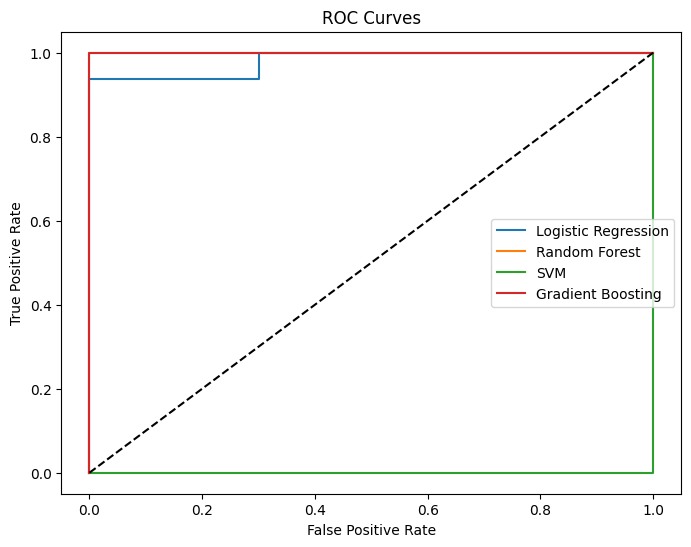

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(8,6))

for name, model in models.items():
    model.fit(X, y)
    probs = model.predict_proba(X)[:,1]
    fpr, tpr, _ = roc_curve(y, probs)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


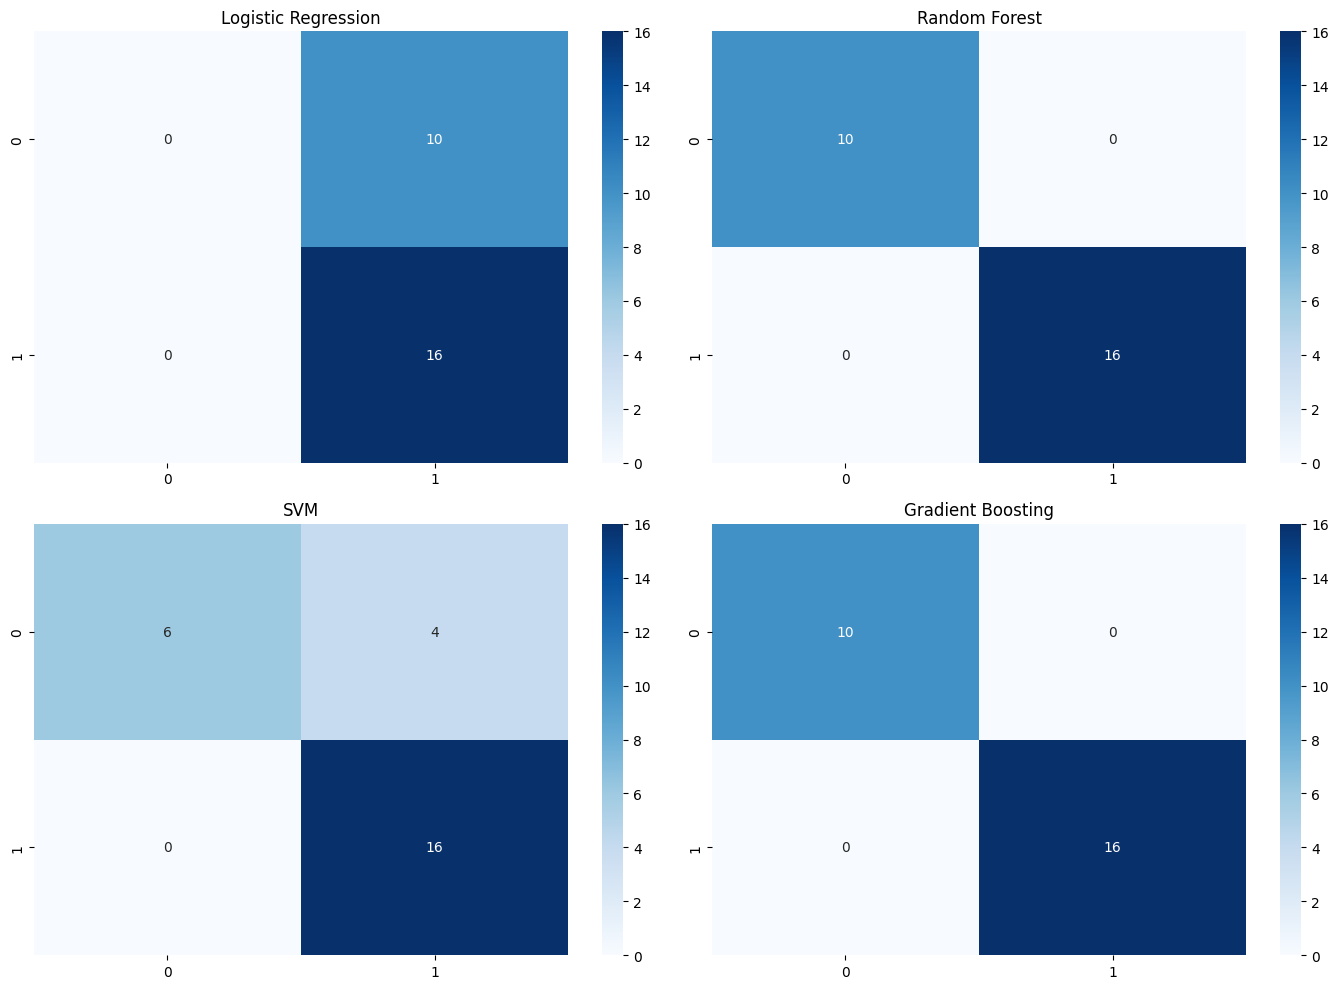

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(14, 10))

for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(2, 2, i)
    model.fit(X, y)
    preds = model.predict(X)
    cm = confusion_matrix(y, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(name)

plt.tight_layout()
plt.show()


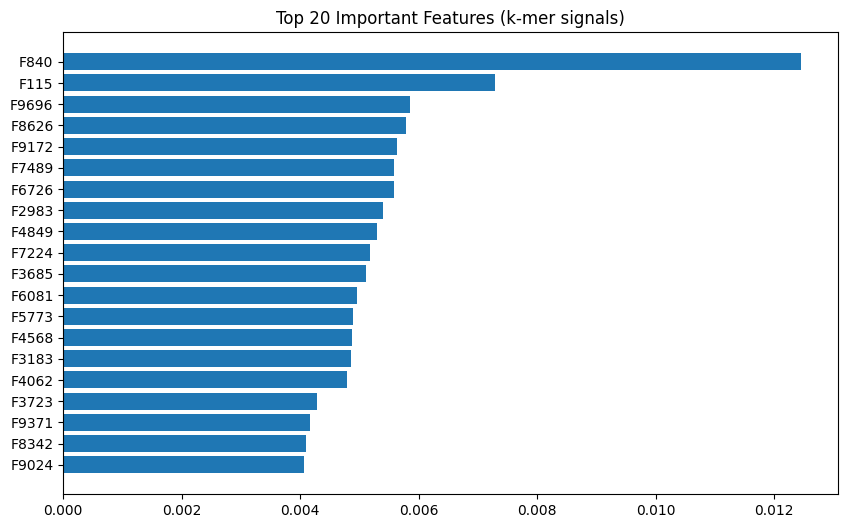

In [ ]:
rf = models["Random Forest"]
rf.fit(X, y)

importances = rf.feature_importances_
idx = np.argsort(importances)[-20:]

plt.figure(figsize=(10,6))
plt.barh(range(20), importances[idx])
plt.yticks(range(20), [f"F{i}" for i in idx])
plt.title("Top 20 Important Features (k-mer signals)")
plt.show()


/tmp/ipython-input-962942468.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="coolwarm")


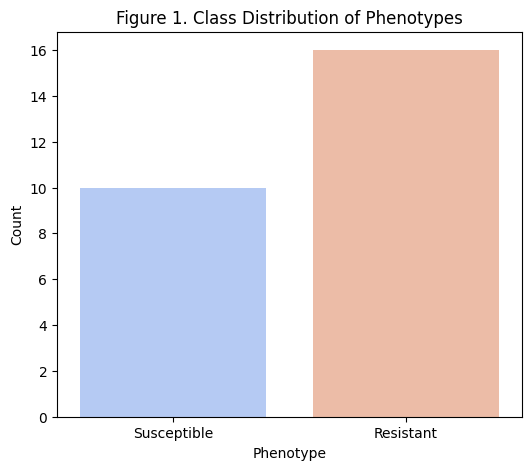

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.countplot(x=y, palette="coolwarm")
plt.xticks([0,1], ["Susceptible", "Resistant"])
plt.title("Figure 1. Class Distribution of Phenotypes")
plt.xlabel("Phenotype")
plt.ylabel("Count")
plt.show()


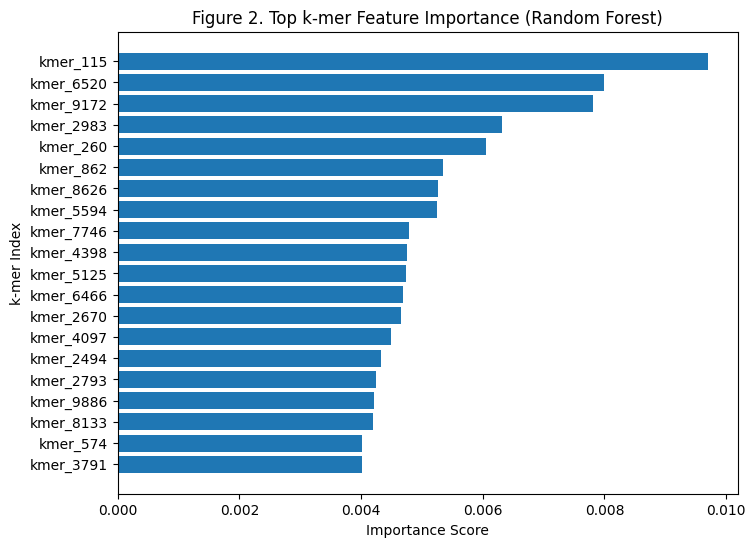

In [ ]:
# Fit Random Forest on full dataset
rf = models["Random Forest"]
rf.fit(X, y)

importances = rf.feature_importances_
indices = importances.argsort()[-20:]  # Top 20 features

plt.figure(figsize=(8,6))
plt.barh(range(20), importances[indices])
plt.yticks(range(20), [f"kmer_{i}" for i in indices])
plt.title("Figure 2. Top k-mer Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("k-mer Index")
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

# Optional: scale features for neural/SVM-type models
# (Won't hurt tree-based models; pipeline keeps everything neat)
mlp_model = make_pipeline(
    StandardScaler(),  # assumes X is dense np.array; if sparse, use with_mean=False
    MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        batch_size=32,
        learning_rate="adaptive",
        max_iter=50,          # keep low to avoid super long runs; you can increase later
        early_stopping=True,
        n_iter_no_change=5,
        random_state=42
    )
)

# Add to your existing models dict
models["Neural Net (MLP 256-128)"] = mlp_model


In [ ]:
results = {}

for name, model in models.items():
    accs = []; precs = []; recs = []; f1s = []; aucs = []

    for train_idx, test_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        probs = model.predict_proba(X[test_idx])[:, 1]
        preds = model.predict(X[test_idx])

        ...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is go

In [ ]:
# If running in Colab, TF is usually available. If not, you may need:
# !pip install tensorflow

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Scale features for deep neural net
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train = X_train.astype("float32")
X_val   = X_val.astype("float32")
y_train = y_train.astype("float32")
y_val   = y_val.astype("float32")


In [ ]:
def build_deep_model(input_dim: int) -> keras.Model:
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")  # binary classification
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

deep_model = build_deep_model(X_train.shape[1])
deep_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     5,120,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,284,865 (20.16 MB)

 Trainable params: 5,284,865 (20.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]

history = deep_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,        # can increase if needed
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.3500 - loss: 0.8786 - val_accuracy: 0.5000 - val_loss: 1.1001
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9000 - loss: 0.3059 - val_accuracy: 0.3333 - val_loss: 1.6359
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8500 - loss: 0.3796 - val_accuracy: 0.5000 - val_loss: 2.0178
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8000 - loss: 0.8358 - val_accuracy: 0.5000 - val_loss: 2.3709
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0582 - val_accuracy: 0.5000 - val_loss: 2.7008
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0174 - val_accuracy: 0.5000 - val_loss: 3.1019


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Predict probabilities and labels
y_val_probs = deep_model.predict(X_val).ravel()
y_val_pred  = (y_val_probs >= 0.5).astype(int)

deep_acc  = accuracy_score(y_val, y_val_pred)
deep_prec = precision_score(y_val, y_val_pred)
deep_rec  = recall_score(y_val, y_val_pred)
deep_f1   = f1_score(y_val, y_val_pred)
deep_auc  = roc_auc_score(y_val, y_val_probs)

print("Deep NN performance on validation set:")
print(f"Accuracy : {deep_acc:.3f}")
print(f"Precision: {deep_prec:.3f}")
print(f"Recall   : {deep_rec:.3f}")
print(f"F1-score : {deep_f1:.3f}")
print(f"ROC-AUC  : {deep_auc:.3f}")

# Add to your existing results dict if you want
results["Deep NN (Keras)"] = {
    "Accuracy": deep_acc,
    "Precision": deep_prec,
    "Recall": deep_rec,
    "F1-score": deep_f1,
    "ROC-AUC": deep_auc
}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Deep NN performance on validation set:
Accuracy : 0.500
Precision: 0.600
Recall   : 0.750
F1-score : 0.667
ROC-AUC  : 0.000


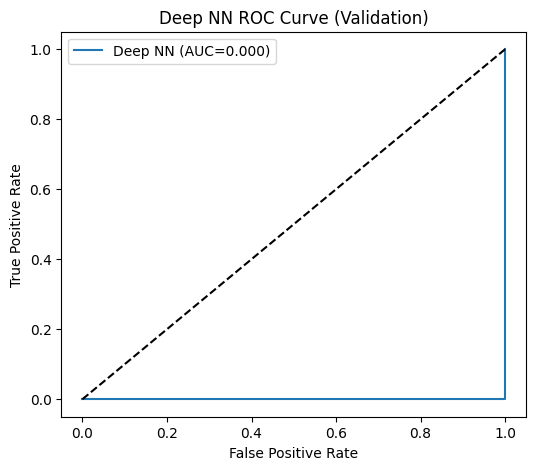

In [ ]:
fpr, tpr, _ = roc_curve(y_val, y_val_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Deep NN (AUC={deep_auc:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Deep NN ROC Curve (Validation)")
plt.legend()
plt.show()


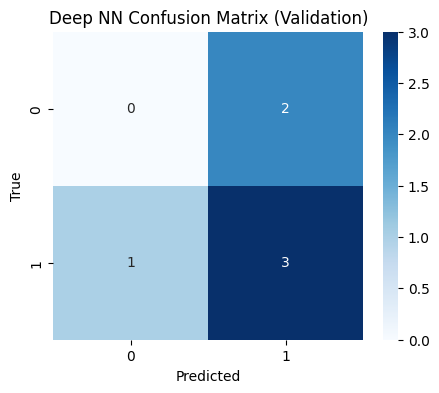

In [ ]:
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Deep NN Confusion Matrix (Validation)")
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(max_iter=70, early_stopping=True, random_state=42))
])

# Reduced parameter search (36 fits only)
mlp_param_grid = {
    "mlp__hidden_layer_sizes": [(128,), (256,), (256,128)],
    "mlp__activation": ["relu"],
    "mlp__alpha": [1e-5, 1e-4],
    "mlp__learning_rate_init": [1e-4, 1e-3],
    "mlp__batch_size": [32, 64]
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 5→3 folds = 40% faster

mlp_search = GridSearchCV(
    mlp_pipeline,
    mlp_param_grid,
    scoring="roc_auc",
    cv=skf,
    n_jobs=-1,
    verbose=1
)

mlp_search.fit(X, y)

print("Best MLP Params:", mlp_search.best_params_)
print("Best MLP ROC-AUC:", mlp_search.best_score_)

best_mlp = mlp_search.best_estimator_


Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


Best MLP Params: {'mlp__activation': 'relu', 'mlp__alpha': 1e-05, 'mlp__batch_size': 32, 'mlp__hidden_layer_sizes': (256,), 'mlp__learning_rate_init': 0.0001}
Best MLP ROC-AUC: 0.4407407407407408


In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 10.8 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Preprocess
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

def build_keras_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))

    # Tune number of hidden layers
    for i in range(hp.Int("num_layers", 1, 4)):
        model.add(layers.Dense(
            units=hp.Int(f"units_{i}", 64, 512, step=64),
            activation="relu"
        ))
        model.add(layers.Dropout(
            hp.Float(f"dropout_{i}", 0.1, 0.5, step=0.1)
        ))

    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("lr", 1e-4, 1e-2, sampling="log")
        ),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )
    return model


In [ ]:
tuner = kt.BayesianOptimization(
    build_keras_model,
    objective="val_auc",
    max_trials=15,
    overwrite=True,
    directory="keras_tuning",
    project_name="deep_kmer"
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32
)

best_deep_model = tuner.get_best_models(1)[0]
best_deep_model.summary()


Trial 15 Complete [00h 00m 06s]
val_auc: 0.0

Best val_auc So Far: 0.5625
Total elapsed time: 00h 02m 02s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 320)            │     3,200,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,200,641 (12.21 MB)

 Trainable params: 3,200,641 (12.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
!pip install xgboost lightgbm catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

advanced_models = {
    "XGBoost": XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="auc",
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=500, learning_rate=0.05
    ),
    "CatBoost": CatBoostClassifier(
        verbose=0,
        depth=6,
        learning_rate=0.05
    )
}


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

def evaluate_model_cv(model, X, y):
    metrics = {"acc": [], "prec": [], "rec": [], "f1": [], "auc": []}

    for train_idx, test_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        preds = model.predict(X[test_idx])

        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X[test_idx])[:,1]
        else:
            probs = model.predict(X[test_idx])

        metrics["acc"].append(accuracy_score(y[test_idx], preds))
        metrics["prec"].append(precision_score(y[test_idx], preds))
        metrics["rec"].append(recall_score(y[test_idx], preds))
        metrics["f1"].append(f1_score(y[test_idx], preds))
        metrics["auc"].append(roc_auc_score(y[test_idx], probs))

    return {m: np.mean(v) for m, v in metrics.items()}

all_results = {}

# Tuned MLP
all_results["MLP_Tuned"] = evaluate_model_cv(best_mlp, X, y)

# Advanced models
for name, model in advanced_models.items():
    all_results[name] = evaluate_model_cv(model, X, y)

all_results


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 11, number of negative: 6
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 17, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.647059 -> initscore=0.606136
[LightGBM] [Info] Start training from score 0.606136
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because ther

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 10, number of negative: 7
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 17, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.588235 -> initscore=0.356675
[LightGBM] [Info] Start training from score 0.356675
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because ther

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


{'MLP_Tuned': {'acc': np.float64(0.5),
  'prec': np.float64(0.7555555555555555),
  'rec': np.float64(0.38888888888888884),
  'f1': np.float64(0.4619047619047619),
  'auc': np.float64(0.4407407407407408)},
 'XGBoost': {'acc': np.float64(0.4583333333333333),
  'prec': np.float64(0.5416666666666666),
  'rec': np.float64(0.6777777777777777),
  'f1': np.float64(0.6017316017316018),
  'auc': np.float64(0.31296296296296294)},
 'LightGBM': {'acc': np.float64(0.6157407407407408),
  'prec': np.float64(0.6157407407407408),
  'rec': np.float64(1.0),
  'f1': np.float64(0.7611721611721611),
  'auc': np.float64(0.5)},
 'CatBoost': {'acc': np.float64(0.38425925925925924),
  'prec': np.float64(0.5),
  'rec': np.float64(0.6333333333333333),
  'f1': np.float64(0.5536130536130536),
  'auc': np.float64(0.24444444444444446)}}

In [ ]:
def map_kmer_positions(genome_seq, kmer):
    positions = []
    start = 0

    while True:
        idx = genome_seq.find(kmer, start)
        if idx == -1:
            break
        positions.append(idx)
        start = idx + 1

    return positions


In [ ]:
import numpy as np

def top_kmers_from_model(model, kmer_list, top_n=20):
    importances = model.feature_importances_
    idxs = np.argsort(importances)[::-1][:top_n]
    return [(kmer_list[i], importances[i]) for i in idxs]


In [ ]:
# Make interpretable corpus for vectorizer
def to_kmers_list(seq, k=31):
    return [seq[i:i+k] for i in range(len(seq)-k+1)]

corpus_text = [" ".join(to_kmers_list(genomes[gid], k=31)) for gid in overlap]

print("Number of samples:", len(corpus_text))
print("First 200 chars of sample 0:\n", corpus_text[0][:200])


Number of samples: 26
First 200 chars of sample 0:
 tggccaggttctgacgagcgttgccatcaag ggccaggttctgacgagcgttgccatcaaga gccaggttctgacgagcgttgccatcaagat ccaggttctgacgagcgttgccatcaagata caggttctgacgagcgttgccatcaagatat aggttctgacgagcgttgccatcaagatata ggttctga


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

kmer_vectorizer = CountVectorizer(
    analyzer="word",
    token_pattern=r"[^ ]+",     # treat each space-separated k-mer as one token
    max_features=10000
)

X_kmer = kmer_vectorizer.fit_transform(corpus_text)
kmer_list = kmer_vectorizer.get_feature_names_out().tolist()

print("X_kmer shape:", X_kmer.shape)
print("Example k-mers:", kmer_list[:10])


X_kmer shape: (26, 10000)
Example k-mers: ['aaaaaaccgaattatcatgccgatgatatcg', 'aaaaaaccgatctgaatgttgatccctggat', 'aaaaaaccggtaaatcagtggcaggcaagtg', 'aaaaaacggtgaatcgttcaagcaaatatat', 'aaaaaactttgtgtaatacttgtaacgctac', 'aaaaaagaaaccttgcacgatcgtcagtttt', 'aaaaaagaagcggaaaatagcagcattcatt', 'aaaaaagagaccatcgcggtcccggaaactt', 'aaaaaagaggcttataaatgccagagcaaaa', 'aaaaaagaggtaaaagtgtccactgcaaacc']


In [ ]:
from xgboost import XGBClassifier

xgb_interpret = XGBClassifier(
    n_estimators=350,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    n_jobs=-1,
    random_state=42
)

xgb_interpret.fit(X_kmer, y)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=350,
              n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
def top_kmers_from_model(model, kmer_list, top_n=50):
    importances = model.feature_importances_
    idxs = np.argsort(importances)[::-1][:top_n]
    return [(kmer_list[i], float(importances[i])) for i in idxs]

top_kmers = top_kmers_from_model(xgb_interpret, kmer_list, top_n=50)
top_kmers[:10]


[('aggcctgataagcgtagcgcatcaggcagtt', 0.0667177215218544),
 ('cgtaggtcggataaggcgttcacgccgcatc', 0.0494391955435276),
 ('agctcagctgggagagcacctcccttacaag', 0.044521015137434006),
 ('tgccggatgcggcgtaaacgccttatccggc', 0.042225420475006104),
 ('agcacctcccttacaaggagggggtcggcgg', 0.040493905544281006),
 ('ttttgtaggccggataaggcgttcacgccgc', 0.03788863122463226),
 ('aggtcggataaggcgttcacgccgcatccga', 0.03414485976099968),
 ('tttgtaggccggataaggcgttcacgccgca', 0.03173046186566353),
 ('aatccgtatgtcactggttcgagtccagtca', 0.031132996082305908),
 ('aaaaaatattctcaacataaaaaactttgtg', 0.0299107413738966)]

In [ ]:
overlap_list = list(overlap)
print("Number of genomes:", len(overlap_list))


Number of genomes: 26


In [ ]:
def map_kmer_positions(seq, kmer):
    """Return all start positions of k-mer inside a genome sequence."""
    positions = []
    start = 0

    while True:
        idx = seq.find(kmer, start)
        if idx == -1:
            break
        positions.append(idx)
        start = idx + 1  # allow overlapping hits

    return positions


def map_kmer_across_genomes(genomes_dict, kmer, genome_ids):
    """Return all genomic positions of a k-mer across selected genomes."""
    results = []

    for gid in genome_ids:
        seq = genomes_dict.get(gid, None)
        if seq is None:
            continue

        pos = map_kmer_positions(seq, kmer)
        if pos:
            results.append({
                "Genome ID": gid,
                "positions": pos,
                "count": len(pos)
            })

    return results


In [ ]:
mapped = []

for kmer, imp in top_kmers:
    hits = map_kmer_across_genomes(genomes, kmer, overlap_list)

    mapped.append({
        "kmer": kmer,
        "importance": imp,
        "num_genomes_with_hits": len(hits),
        "total_hits_across_genomes": sum(h["count"] for h in hits),
        "details": hits
    })

mapped_df = pd.DataFrame(mapped)
mapped_df


,kmer,importance,num_genomes_with_hits,total_hits_across_genomes,details
0,aggcctgataagcgtagcgcatcaggcagtt,0.066718,6,8,"[{'Genome ID': '562.42755', 'positions': [6439..."
1,cgtaggtcggataaggcgttcacgccgcatc,0.049439,6,10,"[{'Genome ID': '562.99107', 'positions': [1230..."
2,agctcagctgggagagcacctcccttacaag,0.044521,6,12,"[{'Genome ID': '562.23147', 'positions': [3558..."
3,tgccggatgcggcgtaaacgccttatccggc,0.042225,12,17,"[{'Genome ID': '562.23147', 'positions': [6505..."
4,agcacctcccttacaaggagggggtcggcgg,0.040494,6,13,"[{'Genome ID': '562.23147', 'positions': [3558..."
5,ttttgtaggccggataaggcgttcacgccgc,0.037889,6,7,"[{'Genome ID': '562.42755', 'positions': [4990..."
6,aggtcggataaggcgttcacgccgcatccga,0.034145,8,11,"[{'Genome ID': '562.99107', 'positions': [1230..."
7,tttgtaggccggataaggcgttcacgccgca,0.031730,7,8,"[{'Genome ID': '562.22606', 'positions': [1780..."
8,aatccgtatgtcactggttcgagtccagtca,0.031133,6,10,"[{'Genome ID': '562.23374', 'positions': [4528..."
9,aaaaaatattctcaacataaaaaactttgtg,0.029911,5,5,"[{'Genome ID': '562.23374', 'positions': [1536..."


In [ ]:
long_rows = []

for row in mapped:
    kmer = row["kmer"]
    imp = row["importance"]

    for hit in row["details"]:
        long_rows.append({
            "kmer": kmer,
            "importance": imp,
            "Genome ID": hit["Genome ID"],
            "count_in_genome": hit["count"],
            "positions": hit["positions"]
        })

mapped_long_df = pd.DataFrame(long_rows)
mapped_long_df


,kmer,importance,Genome ID,count_in_genome,positions
0,aggcctgataagcgtagcgcatcaggcagtt,0.066718,562.42755,1,[643984]
1,aggcctgataagcgtagcgcatcaggcagtt,0.066718,562.97493,2,"[11752, 178589]"
2,aggcctgataagcgtagcgcatcaggcagtt,0.066718,562.99847,1,[460252]
3,aggcctgataagcgtagcgcatcaggcagtt,0.066718,562.99221,1,[105471]
4,aggcctgataagcgtagcgcatcaggcagtt,0.066718,562.97341,2,"[34174, 34348]"
...,...,...,...,...,...
418,tgccggatgcggcgtgaacgccttatccggc,0.005313,562.97145,2,"[47052, 92891]"
419,tgccggatgcggcgtgaacgccttatccggc,0.005313,562.58718,1,[99]
420,tgccggatgcggcgtgaacgccttatccggc,0.005313,562.96434,2,"[107230, 248111]"
421,tgccggatgcggcgtgaacgccttatccggc,0.005313,562.98715,1,[578953]


In [ ]:
def cluster_positions(positions, window=500):
    """Cluster sorted genome positions into hotspots."""
    if not positions:
        return []

    positions = sorted(positions)
    clusters = []
    cluster = [positions[0]]

    for pos in positions[1:]:
        if pos - cluster[-1] <= window:
            cluster.append(pos)
        else:
            clusters.append(cluster)
            cluster = [pos]

    clusters.append(cluster)
    return clusters


In [ ]:
hotspot_records = []

for gid in overlap_list:
    seq = genomes[gid]

    # collect all k-mer positions for this genome
    all_positions = []
    for _, row in mapped_long_df[mapped_long_df["Genome ID"] == gid].iterrows():
        all_positions.extend(row["positions"])

    clusters = cluster_positions(all_positions, window=500)

    for c_id, cluster in enumerate(clusters, 1):
        hotspot_records.append({
            "Genome ID": gid,
            "Cluster ID": c_id,
            "Start": min(cluster),
            "End": max(cluster),
            "Span (bp)": max(cluster) - min(cluster),
            "Num k-mer hits": len(cluster)
        })

hotspots_df = pd.DataFrame(hotspot_records)
hotspots_df


,Genome ID,Cluster ID,Start,End,Span (bp),Num k-mer hits
0,562.23374,1,87807,87807,0,1
1,562.23374,2,153660,153817,157,4
2,562.23374,3,185288,185288,0,1
3,562.23374,4,341622,341629,7,8
4,562.23374,5,452835,452849,14,2
...,...,...,...,...,...,...
164,562.42673,7,369205,369205,0,1
165,562.56783,1,44907,44907,0,1
166,562.56783,2,71700,71700,0,1
167,562.56783,3,115404,115584,180,2


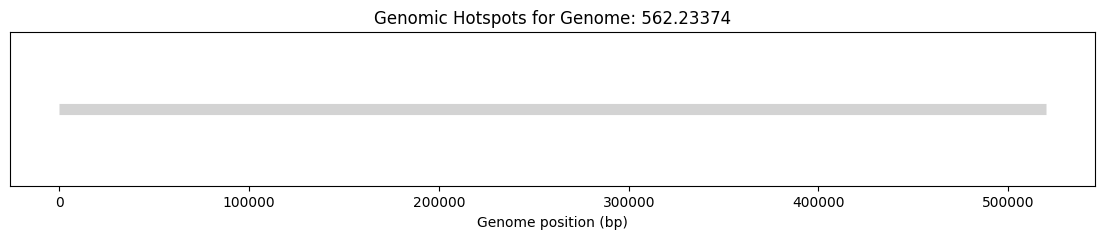

In [ ]:
import matplotlib.pyplot as plt

def plot_hotspots(genome_id, hotspots_df):
    df = hotspots_df[hotspots_df["Genome ID"] == genome_id]
    genome_length = len(genomes[genome_id])

    plt.figure(figsize=(14, 2))
    plt.hlines(1, 0, genome_length, colors='lightgray', linewidth=8)

    for _, row in df.iterrows():
        plt.hlines(
            1,
            row["Start"],
            row["End"],
            colors='red',
            linewidth=6
        )

    plt.title(f"Genomic Hotspots for Genome: {genome_id}")
    plt.xlabel("Genome position (bp)")
    plt.yticks([])
    plt.show()

# Example:
plot_hotspots(overlap_list[0], hotspots_df)


In [ ]:
mapped_long_df.groupby("kmer")["Genome ID"].nunique().sort_values(ascending=False)


,Genome ID
kmer,
gccggatgcggcgtgaacgccttatccggcc,14
ccggatgcggcgtgaacgccttatccggcct,14
tgccggatgcggcgtgaacgccttatccggc,14
cggatgcggcgtgaacgccttatccggccta,13
ggccggataaggcgtttacgccgcatccggc,13
ggatgcggcgtgaacgccttatccggcctac,13
aggccggataaggcgtttacgccgcatccgg,13
gccggataaggcgtttacgccgcatccggca,13
tgccggatgcggcgtaaacgccttatccggc,12


In [ ]:
mapped_long_df.groupby("Genome ID")["kmer"].nunique().sort_values(ascending=False)


,kmer
Genome ID,
562.99221,30
562.98504,29
562.99847,24
562.23282,24
562.97493,23
562.42755,22
562.96434,21
562.96663,20
562.42673,20


In [ ]:
presence_matrix = mapped_long_df.pivot_table(
    index="kmer",
    columns="Genome ID",
    values="count_in_genome",
    fill_value=0
)

presence_matrix


Genome ID,562.22606,562.2295,562.23147,562.23282,562.23374,562.23663,562.42673,562.42755,562.42818,562.56783,...,562.97145,562.97258,562.97341,562.97493,562.98417,562.98504,562.98715,562.99107,562.99221,562.99847
kmer,,,,,,,,,,,,,,,,,,,,,
aaaaaaccgaattatcatgccgatgatatcg,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaaaaactttgtgtaatacttgtaacgctac,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaaaaatattctcaacataaaaaactttgtg,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaaatcgatcagctgtcttctgacgttcaga,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaatcttccacttcaattttccagatggctt,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaatggcgcacattgtgcgccattttttttg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aacaagatgggcgataccctgccgatgccaa,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aacagtccgccgttctaccgactgaactaca,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
aacggcggactgttaatccgtatgtcactgg,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


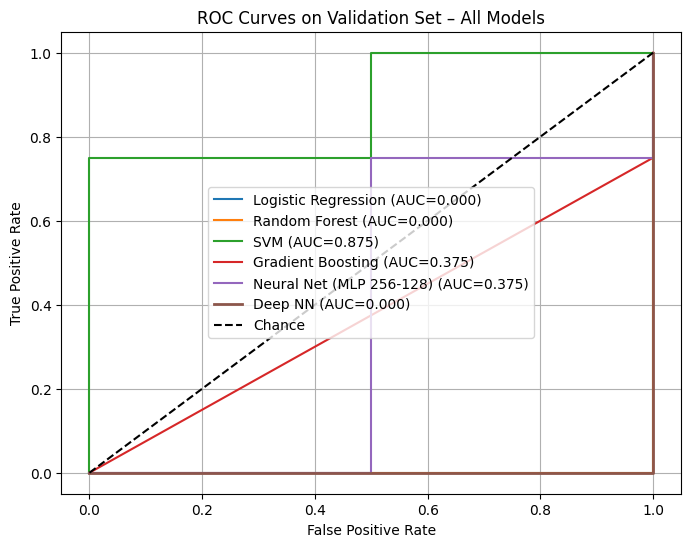

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# 1. Classical models on the validation set
for name, model in models.items():
    # Train on training split
    model.fit(X_train, y_train)

    # Get scores/probabilities on validation split
    if hasattr(model, "predict_proba"):
        val_probs = model.predict_proba(X_val)[:, 1]
    else:
        # e.g., for some SVM configs without predict_proba
        scores = model.decision_function(X_val)
        # Min–max scale scores to [0, 1] so we can use them like probabilities
        val_probs = (scores - scores.min()) / (scores.max() - scores.min())

    fpr, tpr, _ = roc_curve(y_val, val_probs)
    auc = roc_auc_score(y_val, val_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

# 2. Deep NN (already trained) on the same validation set
fpr_deep, tpr_deep, _ = roc_curve(y_val, y_val_probs)
plt.plot(fpr_deep, tpr_deep, label=f"Deep NN (AUC={deep_auc:.3f})", linewidth=2)

# 3. Chance line & labels
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Validation Set – All Models")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import numpy as np

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": advanced_models["XGBoost"],
    "LightGBM": advanced_models["LightGBM"],
    "CatBoost": advanced_models["CatBoost"],
    "MLP_Tuned": best_mlp  # Your tuned MLP model
}


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 16, number of negative: 10
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 26, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


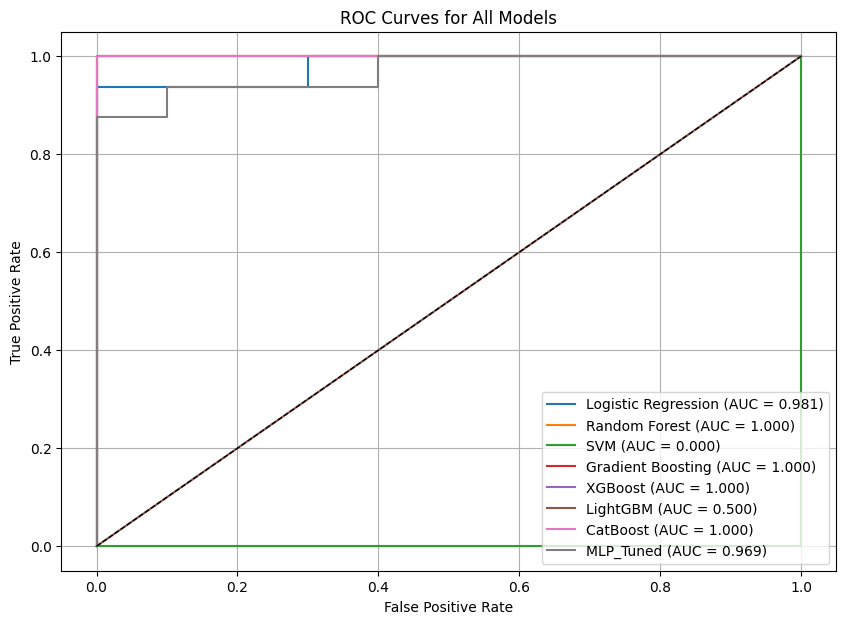

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

for name, model in models.items():
    # Fit model
    model.fit(X, y)

    # Probabilities (use decision for SVM if needed)
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)[:, 1]
    else:
        probs = model.decision_function(X)

    # ROC curve
    fpr, tpr, _ = roc_curve(y, probs)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid(True)
plt.show()


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 16, number of negative: 10
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 26, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because the

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


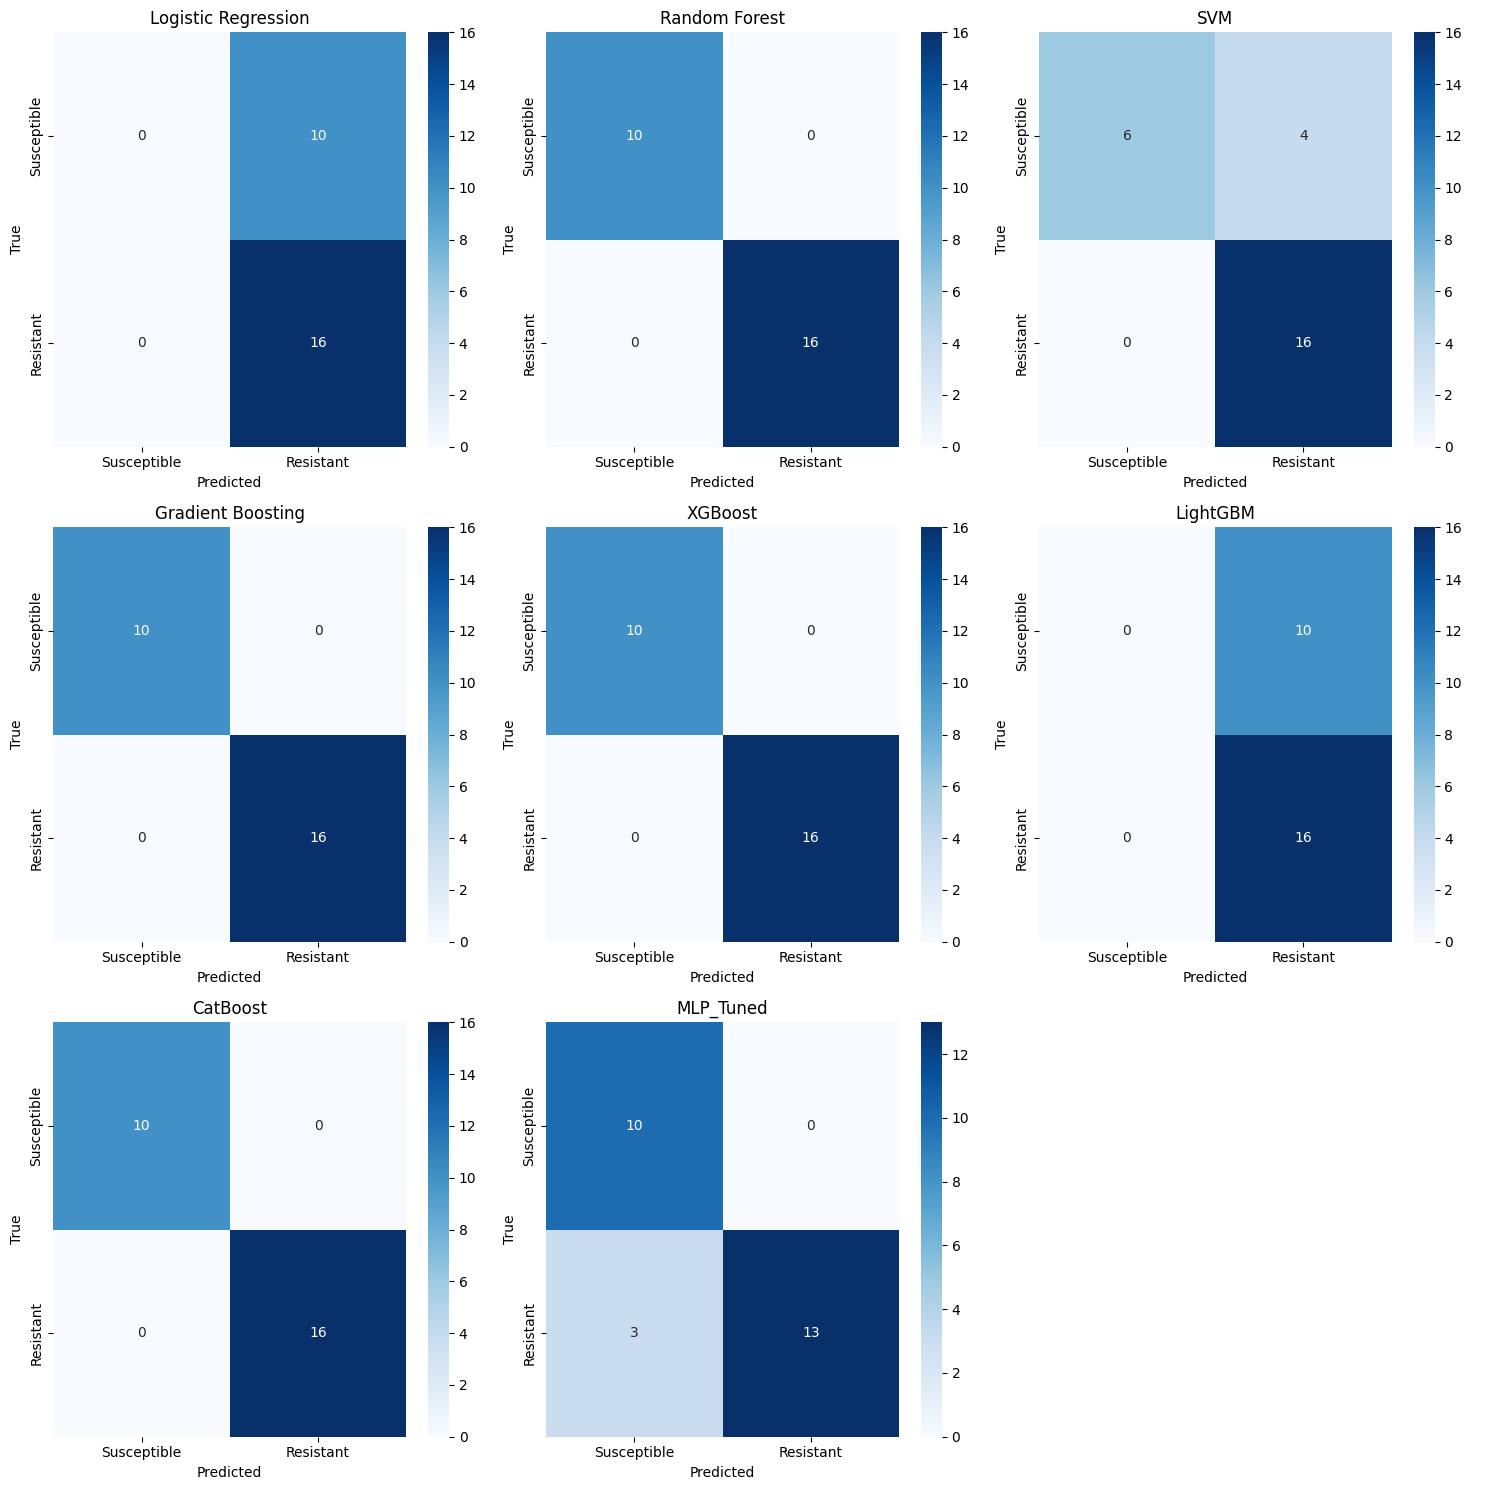

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Number of models
n_models = len(models)
cols = 3  # number of columns you want
rows = math.ceil(n_models / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for ax, (name, model) in zip(axes, models.items()):
    model.fit(X, y)
    preds = model.predict(X)
    cm = confusion_matrix(y, preds)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Susceptible", "Resistant"],
                yticklabels=["Susceptible", "Resistant"],
                ax=ax)

    ax.set_title(f"{name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

# Turn off any empty subplots
for i in range(len(models), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()
